This shows an example of using cooltools.dots to obtain dots for the bonev_2017 data (HiC_ES.mm10.mapq_30.1000.mcool). Since this data is sequenced more deeply & is also for ESC, it may be more reliable than obtaining dots from NIPBL-FKBP-untreated_RSHIC13-21_merge_220502.1000.mcool. 

There is also an example of using mustache dots. For now ( 11/17/22), using mustache dots with slightly more strict FDR cutoff (0.025) seems ideal. 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import cooler
import cooltools
from cooltools.lib.plotting import *
import bioframe
print(cooltools.__version__)

num_processes = 22 # set depending on ondemand request

0.5.2


In [4]:
#load cooler
resolution = 10_000
bonev_cooler_file = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES.mm10.mapq_30.1000.mcool'
bonev_cooler = cooler.Cooler(bonev_cooler_file+'::resolutions/'+str(resolution))
clr = bonev_cooler

view_df  = cooltools.lib.make_cooler_view(clr)
view_df = view_df[ ~view_df.chrom.isin(['chrX','chrY', 'chrM'])]

In [5]:
feature_dir = '/'.join(bonev_cooler_file.split('/')[:-1])+'/features/'
print(feature_dir)

/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features/


In [10]:
max_nans_tolerated=6 # currently can't push this higher
# see: https://open2c.slack.com/archives/CTFSERWAE/p1667612149344639 
# and: https://github.com/open2c/cooltools/blob/94b966e4ceec09ccc9bf79aba67e86c44ea4caa4/cooltools/cli/dots.py#L182
fdr = 0.2
dotfile_name = bonev_cooler_file.split('/')[-1].replace(
    '1000.mcool',f'{resolution}.dots.maxnans{max_nans_tolerated}.fdr{fdr}.tsv')

expected_val_col = 'balanced.avg.smoothed.agg'
if os.path.exists(feature_dir+dotfile_name) is False:
  
    expected = cooltools.expected_cis(
        clr,
        view_df=view_df,
        nproc=num_processes,
        )
    expected.loc[ expected['dist'].values==1, expected_val_col] = np.nan
    
    print('expected done')
    
    dots_df = cooltools.dots(
        clr,
        expected=expected,
        view_df=view_df,
        expected_value_col=expected_val_col,
        max_loci_separation=10_000_000,   # how far from the main diagonal to call dots:
        max_nans_tolerated=max_nans_tolerated, 
        lambda_bin_fdr=fdr,
        nproc=num_processes,
        tile_size = 20_000_000 #try pushing this up to calculate more quickly
    )
    
    dots_df.to_csv(feature_dir+dotfile_name, sep='\t', index=False)
else:
    print('exists')
    dots_df = pd.read_table(feature_dir+dotfile_name)

exists


In [12]:
dots_df['strength'] = dots_df['count'].values / dots_df['la_exp.donut.value'].values

In [ ]:
## ran mustache (https://github.com/ay-lab/mustache) using mustache_env from quaich:
# https://github.com/open2c/quaich/blob/master/workflow/envs/mustache_env.yml

# salloc --time=4:00:00 --cpus-per-task=32 --mem=32GB --account=fudenber_735 --partition=qcbr
# mustache -r 10000 -o features/mustache_HiC_ES.mm10.mapq_30.10000.tsv -f 'HiC_ES.mm10.mapq_30.1000.mcool' -d 5000000 -pt 0.05 -st 0.8 --processes 24


In [21]:
df_mustache = pd.read_csv(feature_dir+'mustache_HiC_ES.mm10.mapq_30.10000.tsv', sep='\t')
df_mustache.rename(columns={'BIN1_CHR':'chrom1','BIN1_START':'start1','BIN1_END':'end1',
                            'BIN2_CHR':'chrom2','BIN2_START':'start2','BIN2_END':'end2'
                            },inplace=True)

/tmp/SLURM_9433526/ipykernel_21954/3348570311.py:11: RuntimeWarning: divide by zero encountered in log10
  im = plt.matshow(np.log10(mat),


Text(0.5, 1.0, 'chr1:4000000-9000000')

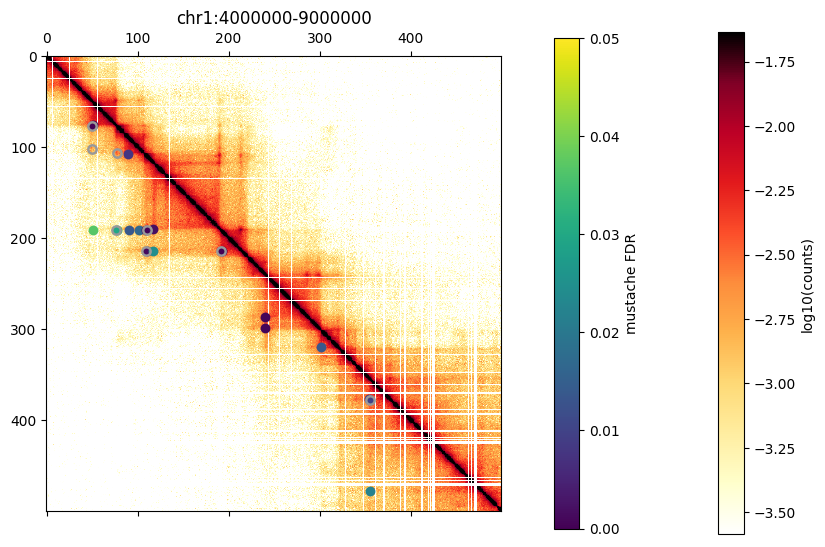

In [68]:
%matplotlib inline
plt.figure(figsize=(9,9))

res=10000
region = 'chr1:4000000-9000000'
#region = 'chr1:12000000-18000000'
region_start = int(region.split(':')[1].split('-')[0])
region_end = int(region.split(':')[1].split('-')[1])
region_chrom = region.split(':')[0]
mat = clr.matrix(balance=True).fetch(region)
im = plt.matshow(np.log10(mat), 
                 vmax = np.log10(np.nanmedian(np.diag(mat,2))), 
                 vmin= np.log10(np.nanmedian(np.diag(mat,2)))-1.95, 
                 fignum=False ,cmap='fall' ); 
plt.colorbar(im ,fraction=0.036, pad=0.2, label='log10(counts)')


region_dots = bioframe.select( df_mustache, region, cols=['chrom1','start1','end1'])
for i in range(len(region_dots)):
    s1,s2,e1,e2 =( ( region_dots[['start1','end1','start2','end2']].iloc[i].values.astype(int)
                    -region_start) //res ) 
    s,e = .5*(s1+s2), .5*(e1+e2)
    if s < 0 or e > len(mat): continue
    if  region_dots.iloc[i].FDR > .05: continue
    scat = plt.scatter(  s,e,50,region_dots.iloc[i].FDR, lw=0 ,vmin=0,vmax=0.05)# ,mew=2.25,color=[.99,0,.99],mfc='none')

region_dots = bioframe.select( dots_df, region, cols=['chrom1','start1','end1'])
for i in range(len(region_dots)):
    s1,s2,e1,e2 =( ( region_dots[['start1','end1','start2','end2']].iloc[i].values.astype(int)
                    -region_start) //res ) 
    s,e = .5*(s1+s2), .5*(e1+e2)
    if s < 0 or e > len(mat): continue
    plt.plot(  s,e,'o',mew=1.75,color=[.6,.6,.6],mfc='none')
    
plt.colorbar(scat, fraction=0.046, pad=0.1, label=
            'mustache FDR')
plt.title(region)